
<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction to Python for Data Sciences</h1></center></td>
<td width=15%><a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a><br/> 2017/2018 </td>
</tr>
</table>


<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">Chap. 2 - Python for Scientific Computing </a></center>

<br/>

# ``2. Signal Processing and Optimization``

---

<a href="#style"><b>Package check and Styling</b></a><br/><br/><b>Outline</b><br/><br/>
&nbsp;&nbsp;&nbsp; a) <a href="#sigEx"> Example: Compressed Sensing </a><br/>

## <a id="sigEx"> a) Example: Compressed Sensing </a> 

<p style="text-align: right; font-size: 10px;"><a href="#top">Go to top</a></p>

In [1]:
import numpy as np
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
%matplotlib inline

In this example (borrowed from Kutz, J. N. “Data-driven modeling and scientific computing: Methods for Integrating Dynamics of Complex Sys-tems and Big Data.” (2013)), we will create an artificial periodic signal, sample 5% of it, and try to reconstruct the original signal using the prior knowledge that the signal should be *simple* in the cosine (frequencial) domain. 

In practice:
* The original temporal signal $x$ will be generated
* Our observed subsampled signal $y$ will be obtained by randomly sampling 5% of the original signal, we will see that standard interpolation may be bad 
* The discrete cosine tranform (DCT) matrix $T$ will be obtained from <tt>scipy.fftpack</tt> (from the frequencial coefficients $Y$,  the matrix $T$, s.t. $T_{i,j} \propto \cos(2\pi f_j t_i)$, enables to retreive the temporal signal $y = TY$)
* We will recover an estimate $\hat{Y}$ of the DCT $X$ of $x$ by minimizing $\|y - TY\|$ over $Y$ under the contraint that $Y$ should be somehow sparse
* From the coefficient $\hat{Y}$, we can oversample to get an estimate $\hat{x}$

This is one dimensional **compressed sensing**.

### Problem Setup

First, create a signal of two sinusoids.

In [2]:
n = 200  # number of original discrete points
tMax = 2.0 # total signal time in sec

t = np.linspace(0, tMax , n) 

f1 = 5.75; f2 = 15.0;
x = 2*np.sin(f1 * np.pi * t) + 1.5*np.sin(f2 * np.pi * t)
X = spfft.dct(x, norm='ortho')


f = (np.arange(n)+0.5)/tMax

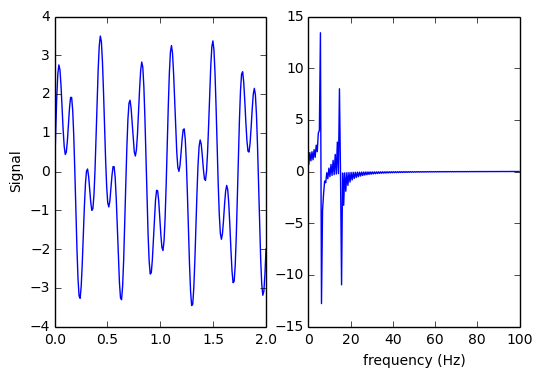

In [3]:
plt.subplot(121)
plt.plot(t,x)
plt.ylabel("Signal")

plt.subplot(122)
plt.plot(f,X)
plt.xlabel("frequency (Hz)")

In [4]:
# extract small sample of signal
m = int(n*0.15) # 5% sample
iS = np.sort(np.random.choice(n, m, replace=False)) # random sample of indices

tS = t[iS]
y  = x[iS]

(0, 2.0)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


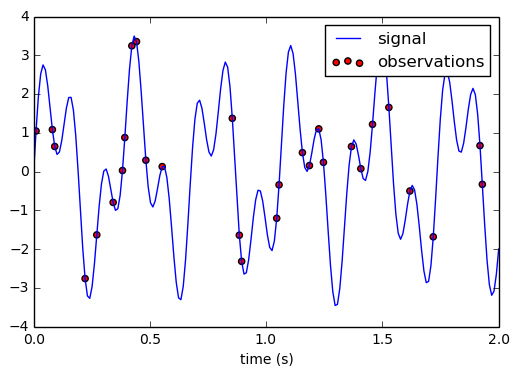

In [5]:
plt.plot(t,x,label="signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.xlabel("time (s)")
plt.legend()
plt.xlim([0,tMax])

### Interpolation


Scipy posseses an [interpolation module](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) that enables direct interpolation using splines.

In [6]:
import scipy.interpolate as spinter

tInt =  np.clip(t, min(tS), max(tS)) # We can only interpolate between the sampled values

intL = spinter.interp1d(tS, y , kind = "linear")
xL = intL(tInt)
intC = spinter.interp1d(tS, y , kind = "cubic")
xC = intC(tInt)

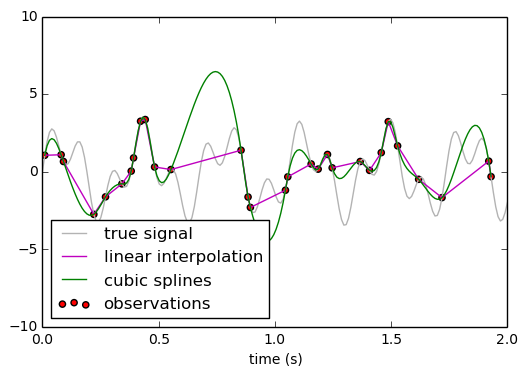

In [7]:
plt.plot(t,x ,c='0.7',label="true signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.plot(tInt,xL ,c='m',label="linear interpolation")
plt.plot(tInt,xC ,c='g',label="cubic splines")
plt.xlabel("time (s)")
plt.xlim([0,tMax])
plt.ylim([-10,10])
plt.legend(loc="lower left")

We see that interpolation is bad as we have *very few* points from a *complicated* signal in the temporal space. In Compressed sensing, we are going to use the signal *simplicity* in the cosine domain. 

### Compressed Sensing


The inverse discrete cosine tranform (IDCT) matrix $T$ will be obtained from <tt>scipy.fftpack</tt> (from the frequencial coefficients $Y$,  the matrix $T$, s.t. $T_{i,j} \propto \cos(2\pi f_j t_i)$, enables to retreive the temporal signal $y = TY$).

In [8]:
# create idct matrix operator
T = spfft.idct(np.identity(n), norm='ortho', axis=0)
T = T[iS]

We now want to recover an estimate $\hat{Y}$ of the DCT $X$ of $x$ by minimizing $\|y - TY\|$ over $Y$ under the contraint that $Y$ should be somehow sparse. 

To address this problem, two popular solutions are: 
* the **Dantzig Selector**, introduced in *Emmanuel Candes and Terrence Tao "The Dantzig selector: Statistical estimation when $p$ is much larger than $n$". The Annals of Statistics, 2007* can be used to compute $\hat{Y}$ in the case of an overparametrized problem, i.e. when the dimension $n$ of $\hat{Y}$ is well greater than the dimension $m$ of the observation $y$. <br/> In that case, the estimator $\widehat{Y}_{DS}$ is the solution of the optimization problem 
$$
\widehat{Y}_{DS} \in \arg\min_{Y\in \mathbb{R}^n} \left\{\|Y\|_1,\;\mbox{with}\;\|T^T(TY-y)\|_\infty\leq \kappa\sigma\right\},
$$
where $\sigma>0$ is an *hyper-parameter*. 

* the **Least Absolute Shrinkage and Selection Operator** or **lasso**, introduced in *Robert Tibshirani "Regression shrinkage and selection via the lasso", Journal of the Royal Statistical Society, 1996* can also be used to estimate $Y$. <br/> The estimator $\widehat{Y}_{L}$ is the solution of the optimization problem 
$$
\widehat{\theta}_{L} \in \arg\min_{\theta\in \mathbb{R}^n} \left\{ \|X\theta - y\|_2^2 + \kappa \sigma \|\theta\|_1 \right\},
$$
where $\sigma>0$ is an *hyper-parameter*. 

<div id="warn">
<b>Warning:</b> Below is the code for both estimators using <tt>cvxopt</tt> for solving linear or quadratic reformulated problems. <b><i>you are strongly encouraged to take a deeper look at these functions.</i></b>
</div>

In [18]:
from cvxopt import matrix, solvers
from scipy.stats import norm
import numpy as np

def DantzigSelector(y,X,sigma):
    
    # Extracting the sizes
    m,n = X.shape
    
    # Computing kappa
    alpha = 0.05
    nu = max(np.linalg.norm(X, axis=0))
    kappa = nu*norm.ppf(1-alpha/(2.0*n)) 

    # Computing LP
    
    c = matrix(np.concatenate((np.zeros(n),np.ones(n))))
    
    G1 = np.hstack((np.eye(n),-np.eye(n)))
    G2 = np.hstack((-np.eye(n),-np.eye(n)))
    G3 = np.hstack((np.dot(X.T,X),np.zeros((n,n))))
    G4 = np.hstack((-np.dot(X.T,X),np.zeros((n,n))))
    
    G = matrix(np.vstack((G1,G2,G3,G4)))
    
    h = matrix(np.concatenate( ( np.zeros(n) , np.zeros(n) , kappa*sigma*np.ones(n) + np.dot(X.T,y) , kappa*sigma*np.ones(n) - np.dot(X.T,y) )  ))

    # Solving LP
    sol=solvers.lp(c,G,h) 
    theta = sol['x'][0:n]
    
    return  np.array(theta)

In [10]:
sigmaDS = 1e-1

YDS = DantzigSelector(y,T,sigmaDS)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.6944e+01  2e+03  4e+00  2e+00  1e+00
 1:  4.8693e+01  2.7523e+01  4e+02  1e+00  7e-01  2e+00
 2:  3.6505e+01  2.1851e+01  2e+02  1e+00  5e-01  2e+00
 3:  4.3028e+01  3.7125e+01  8e+01  4e-01  2e-01  7e-01
 4:  4.5535e+01  4.2561e+01  3e+01  2e-01  1e-01  3e-01
 5:  4.7252e+01  4.6428e+01  8e+00  5e-02  3e-02  4e-02
 6:  4.8018e+01  4.7710e+01  3e+00  2e-02  9e-03  1e-02
 7:  4.8259e+01  4.8092e+01  2e+00  1e-02  5e-03  6e-03
 8:  4.8456e+01  4.8409e+01  4e-01  3e-03  1e-03  1e-03
 9:  4.8501e+01  4.8480e+01  2e-01  1e-03  6e-04  5e-04
10:  4.8526e+01  4.8520e+01  6e-02  4e-04  2e-04  1e-04
11:  4.8536e+01  4.8534e+01  1e-02  8e-05  4e-05  3e-05
12:  4.8538e+01  4.8538e+01  5e-04  3e-06  2e-06  9e-07
13:  4.8538e+01  4.8538e+01  5e-06  3e-08  2e-08  9e-09
Optimal solution found.


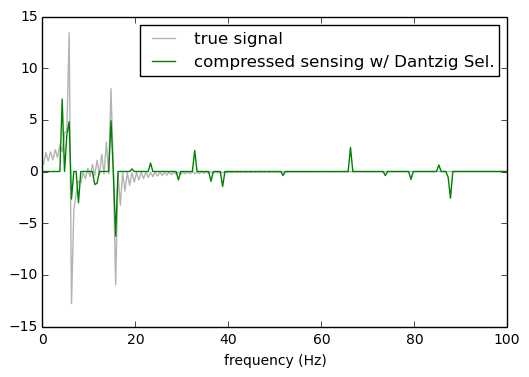

In [11]:
plt.plot(f,X ,c='0.7',label="true signal")
plt.plot(f,YDS ,c='g',label="compressed sensing w/ Dantzig Sel.")
plt.xlabel("frequency (Hz)")
#plt.xlim([0,100])
plt.legend()

From the *reconstructed frequential signal* $\hat{Y}$, we can retreive the full signal by inverse DCT.

In [12]:
xDS = spfft.idct(YDS, norm='ortho', axis=0)

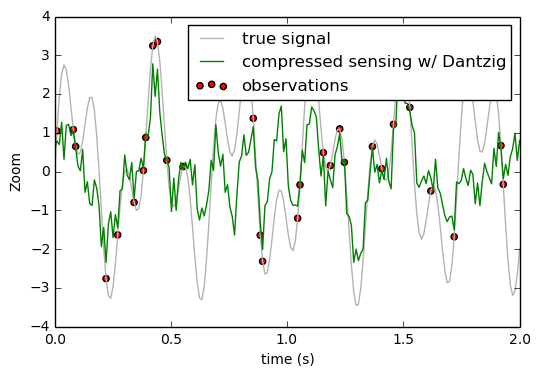

In [13]:
plt.plot(t,x ,c='0.7',label="true signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.plot(t,xDS ,c='g',label="compressed sensing w/ Dantzig")
plt.xlabel("time (s)")
plt.ylabel("Zoom")
plt.xlim([0,tMax])
plt.legend()

<div class="exo">
**Exercise 2.2.1:** Lasso 
<br/><br/>

We can try the same thing for the lasso. Implement a Lasso function in the model of the Dantzig Selector.

The reader is invited to play with the hyperparameter $\sigma$.

</div>



In [22]:
def Lasso(y,X,sigma):
    
    # Extracting the sizes
    m,n = X.shape
    
    return np.zeros((n,1)) #....................

In [23]:
sigma = 0.1

YLa = Lasso(y,T,sigma)

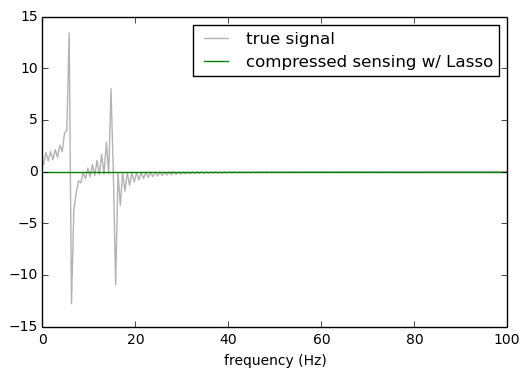

In [24]:
plt.plot(f,X ,c='0.7',label="true signal")
plt.plot(f,YLa ,c='g',label="compressed sensing w/ Lasso")
plt.xlabel("frequency (Hz)")
#plt.xlim([0,100])
plt.legend()

In [25]:
xLa = spfft.idct(YLa, norm='ortho', axis=0)

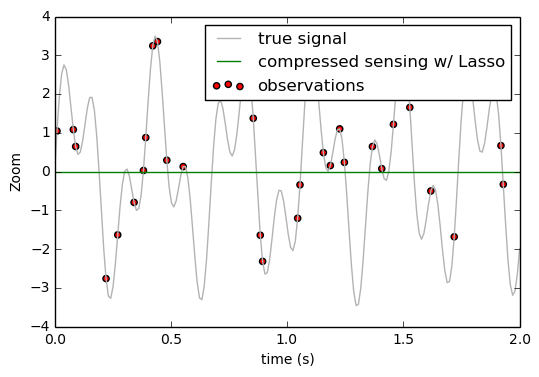

In [26]:
plt.plot(t,x ,c='0.7',label="true signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.plot(t,xLa ,c='g',label="compressed sensing w/ Lasso" )
plt.xlabel("time (s)")
plt.ylabel("Zoom")
plt.xlim([0,tMax])
plt.legend()

---

---
<div id="style"></div>
### Package Check and Styling


<p style="text-align: right; font-size: 10px;"><a href="#top">Go to top</a></p>


In [ ]:
import lib.notebook_setting as nbs

packageList = ['IPython', 'numpy', 'scipy', 'matplotlib', 'cvxopt', 'pandas', 'seaborn', 'sklearn', 'tensorflow']
nbs.packageCheck(packageList)

nbs.cssStyling()